In [63]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(123)

# Recurrent switching Linear Dynamical Systems

## Switching linear dynamical systems

At each time $t$, our model has a *discrete latent state* $z_t$ that follows Markovian dynamics with a given Markov transition matrix $\{\pi_k\}_{k=1}^K$:
$$
z_t\in \{1,2,\dots,K\} \\

z_{t+1} | z_t, \{\pi_k\}_{k=1}^K \sim \pi_{z_t}
$$

where $\pi_{z_t}$ is the probability distribution for the next state, i.e. the $z_t$ th row of $\{\pi_k\}_{k=1}^K$.

The discrete state $z_t$ decides which parameters to use for the dynamics of the continuous variables. 
In particular, we have another *latent* but *continuous state* $x_t$ of $M$ variables that follows the conditionally linear dynamic:

_??? A_t? or A_t+1_?

$$
x_{t+1} = A_{z_{t+1}} x_t + b_{z_{t+1}} +v_t \\
v_t \overset{\text{iid}}{\sim} \mathcal{N}(0,Q_{z_{t+1}})
$$

With covariance matrix $Q_{z_{t+1}}\in \mathbb{R}^{M\times M}$, coefficients matrix $A_{z_{t+1}}\in \mathbb{R}^{M\times M}$, and vector $b_{z_{t+1}}\in \mathbb{R}^{M}$ all depending on the state $z$.

And finally, the $N$ variables of the observed time series $y_t$ are assumed to be dependent on the latent variables via a linear relation:

$$
y_{t} = C_{z_t} x_t + d_{z_{t}} +w_t \\
w_t \overset{\text{iid}}{\sim} \mathcal{N}(0,S_{z_{t}})
$$

again, with covariance matrix $S_{z_t}\in \mathbb{R}^{N\times N}$, coefficients matrix $C_{z_{t+1}}\in \mathbb{R}^{N\times M}$, and vector $d_{z_{t+1}}\in \mathbb{R}^{N}$.

In total, we have

$$
\theta = \{ ( \pi_k,A_k,Q_k,b_k,C_k,S_k,d_k ) \}_{k=1}^K
$$

parameters.


In [78]:
# number of discrete states
K=3

# number of latent variables
M = 2

# number of observed variables
N = 1

# transition matrix
pi = np.array([
    [0.25,0.5,0.25],
    [0.1,0.1,0.8],
    [0.6,0.2,0.2]
])

# generate some random A,b,C,d, and set Q and S equal to I for every k

A = np.random.randn(K,M,M)
b = np.random.randn(K,M)
Q = np.eye(M,M)

C = np.random.randn(K,N,M)
d = np.random.randn(N)
S = np.eye(N)

# logistic function
sigma = lambda x : 1/(1+np.exp(x))

## Recurrent Switching State Space Models

But in this model, there is no dependency on the state space; the next state probability $P(z_{t+1})$ is a Markovian *open loop* (???), i.e. it only depends on the current state $z_{t}$. But we want a dependency on the state space as well, and to capture that, we let the transition depend on additional covariates, in particular the latent variable state $x_t$:

$$
z_{t+1} | z_t,x_t,{R_k,r_k} \sim \pi_{SB} (\nu_{t+1}) \\
v_{t+1} = R_{z_t}x_t + r_{z_t}
$$

where $\pi_{SB}$ is a stick breaking logistic regression.

Unlike the standard multiclass logistic regression, which uses the softmax link function (the logistic function), here we use a _stick breaking link function_

$$
\pi_{SB} : \mathbb{R}^{K-1} \to [0,1]^{K}
$$

which maps a real vector ($\nu$) to a normalized probability vector via the stick breaking process:

$$
\pi_{SB}(\nu) = (\pi_{SB}^{(1)}(\nu),\dots,\pi_{SB}^{(K)}(\nu)) \\
\pi_{SB}^{(k)}(\nu) = \sigma(\nu_k) \prod_{j<k} (1-\sigma(\nu_j))=\sigma(\nu_k) \prod_{j<k} \sigma(\nu_j)
$$

for $k=1,2,\dots,K-1$ and $\pi_{SB}^{(K)}(\nu) = \prod_{k=1}^K \sigma(-\nu_k)$, where $\sigma(x)=e^x /(1+e^x)$ is the logistic function.

Note that the $\nu_k$ are the hyperplanes obtained from $R$ and $r$, and the $\pi_{SB}$ iteratively "chops off" parts of the state space by combining logistic regressions.


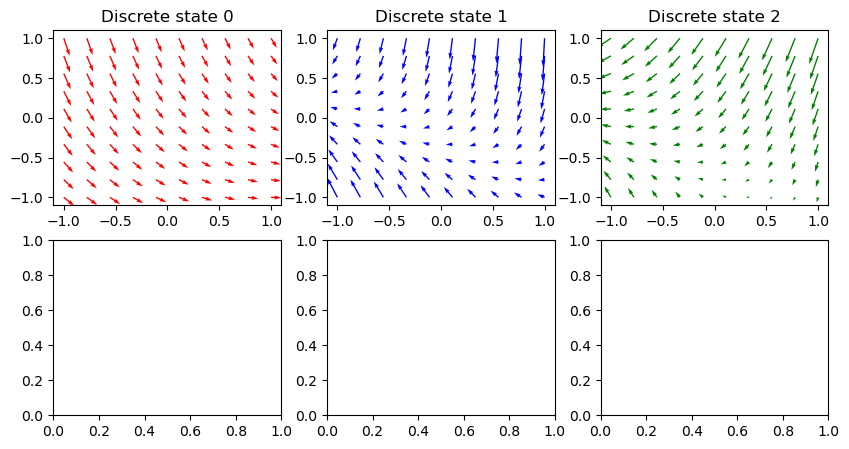

In [117]:
# initialize planes
R = np.random.randn(K,K,M)
r = np.random.randn(K,K)

# plot the dynamics
fig,axs=plt.subplots(2,K,figsize=[10,5])
colors = ['red','blue','green']

# create the grid over X1 and X2
res = 10
X1 = np.linspace(-1,1,res) # is a vector of X1
X2 = np.linspace(-1,1,res) # is a vector of X2
X1,X2 = np.meshgrid(X1,X2)
X1,X2 = X1.flatten(),X2.flatten()
X = np.vstack((X1,X2))

# assume starting state is 0, then we calculate the transition probability
# to any other state using parameters
nu = R[0] @ X + r[0].reshape(-1,1)

for k in range(K):

    # now X is a vector of (M,res**2) dimension
    X_next = A[k] @ X + b[k].reshape(-1,1)
    arrows = X_next - X

    axs[0,k].quiver(X[0],X[1],arrows[0],arrows[1],color=colors[k])
    axs[0,k].set_title('Discrete state '+str(k))

    # axs[1,k].contourf(X[0],X[1],)




